In [0]:
import numpy as np
import tensorflow as tf
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Tensorflow and Deep Learning

In this lab assignment, first you will learn how to build and train a neural network that recognises handwritten digits, and then you will build LeNet-5 CNN architecture, which is widely used for handwritten digit recognition. At the end of this lab assignment, you will make AlexNet CNN architecture, which won the 2012 ImageNet ILSVRC challenge.

---
# 1. Dataset
In the first part of the assignment, we use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. There are 70,000 images, and each image has 784 features. This is because each image is 28×28=784 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The following figure shows a few images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src="figs/1-mnist.png" style="width: 300px;"/>

To begin the assignment, first, use `mnist_data.read_data_sets` and download images and labels. It return two lists, called `mnist.test` with 10K images+labels, and `mnist.train` with 60K images+labels.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

#import data
mnist = mnist_data.read_data_sets("MNIST_data/", one_hot=True, reshape=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


---
# 2. A One-Layer Neural Network
<img src="figs/2-comic1.png" style="width: 500px;"/>

Let's start by building a one-layer neural network. Handwritten digits in the MNIST dataset are 28x28 pixel greyscale images. The simplest approach for classifying them is to use the 28x28=784 pixels as inputs for a **one-layer neural network**. Each neuron in the network does a weighted sum of all of its inputs, adds a bias and then feeds the result through some non-linear activation function. Here we design a one-layer neural network with 10 output neurons since we want to classify digits into 10 classes (0 to 9).
<img src="figs/3-one_layer.png" style="width: 400px;"/>


For a classification problem, an *activation function* that works well is **softmax**. Applying softmax on a vector is done by taking the exponential of each element and then normalising the vector.
<img src="figs/4-softmax.png" style="width: 300px;"/>

We can summarise the behaviour of this single layer of neurons into a simple formula using a *matrix multiply*. If we give input data into the network in *mini-batch* of 100 images, it produces 100 predictions as the output. We define the **weights matrix $W$** with 10 columns, in which each column indicates the weight of a one class (a single digit), from 0 to 9. Using the first column of $W$, we can compute the weighted sum of all the pixels of the first image. This sum corresponds to the first neuron that points to the number 0. Using the second column of $W$, we do the same for the second neuron (number 1) and so on until the 10th neuron. We can then repeat the operation for the remaining 99 images in the mini-batch. If we call $X$ the matrix containing our 100 images (each row corresponds to one digit), all the weighted sums for our 10 neurons, computed on 100 images are simply $X.W$. Each neuron must now add its bias. Since we have 10 neurons, we have 10 bias constants. We finally apply the **softmax activation function** and obtain the formula describing a one-layer neural network, applied to 100 images.
<img src="figs/5-xw.png" style="width: 600px;"/>
<img src="figs/6-softmax2.png" style="width: 500px;"/>

Then, we need to use the **cross-entropy** to measure how good the predictions are, i.e., the distance between what the network tells us and what we know to be the truth. The cross-entropy is a function of weights, biases, pixels of the training image and its known label. If we compute the partial derivatives of the cross-entropy relatively to all the weights and all the biases, we obtain a **gradient**, computed for a given image, label and present value of weights and biases. We can update weights and biases by a fraction of the gradient and do the same thing again using the next batch of training images.
<img src="figs/7-cross_entropy.png" style="width: 600px;"/>

### Define Variables and Placeholders
First we define TensorFlow **variables** and **placeholders**. *Variables* are all the parameters that you want the training algorithm to determine for you (e.g., weights and biases). *Placeholders* are parameters that will be filled with actual data during training (e.g., training images). The shape of the tensor holding the training images is [None, 28, 28, 1] which stands for:
  - 28, 28, 1: our images are 28x28 (784) pixels x 1 value per pixel (grayscale). The last number would be 3 for color images and is not really necessary here.
  - None: this dimension will be the number of images in the mini-batch. It will be known at training time.

We also need an additional placeholder for the training labels that will be provided alongside training images.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784] 
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y_hat [batch, 10]

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

# correct answers will go here
Y = tf.placeholder(tf.float32, shape=[None, 10])

# weights W[784, 10], 784 = 28 * 28
W = tf.Variable(tf.zeros([784, 10]))

# biases b[10]
b = tf.Variable(tf.zeros([10]))

### Build The Model
Now, we can make a **model** for a one-layer neural network. The formula is the one we explained before, i.e., $\hat{Y} = softmax(X . W + b)$. You can use the `tf.nn.softmax` and `tf.matmul` to build the model. Here, we need to use the `tf.reshape` to transform our 28x28 images into single vectors of 784 pixels.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# flatten the images into a single line of pixels
XX = tf.reshape(X,[-1,784]) #problem here since it should be of size [none, 784]

# The model
Y_hat = tf.nn.softmax(tf.matmul(XX,W) + b)

### Define The Cost Function
Now, we have model predictions $\hat{Y}$ and correct labels $Y$, so for each instance $i$ (image) we can compute the cross-entropy as the **cost function**: $cross\_entropy = -\sum(Y_i * log(\hat{Y}i))$. You can use `reduce_mean` to add all the components in a tensor.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

cross_entropy = -tf.reduce_sum(Y*tf.log(Y_hat))

### Traine the Model
Now, select the gradient descent optimiser `GradientDescentOptimizer` and ask it to minimise the cross-entropy cost. In this step, TensorFlow computes the partial derivatives of the cost function relatively to all the weights and all the biases (the gradient). The gradient is then used to update the weights and biases. Set the learning rate is $0.005$.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

learning_rate = 0.005

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

### Execute the Model
It is time to run the training loop. All the TensorFlow instructions up to this point have been preparing a computation graph in memory but nothing has been computed yet. The computation requires actual data to be fed into the placeholders. This is supplied in the form of a Python dictionary, where the keys are the names of the placeholders. During the trainig print out the cost every 200 steps. Moreove, after training the model, print out the accurray of the model by testing it on the test data.

In [0]:
# TODO: Replace <FILL IN> with appropriate code
from matplotlib import pyplot as plt
train_accuracies = []
test_accuracies = []
costs = []

# init
init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
      sess.run(train_step, {XX: batch_xs, Y: batch_ys})
      
      if n % 100 == 0:
        cost, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={XX: mnist.train.images, Y: mnist.train.labels})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels})
        print("current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
        
               
    print("----------------------------------------------")
    final_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels})
    print("Final Model Accuracy: {0} %".format(round(final_accuracy*100, 2)))
    print("Final Cost: {0}".format(round(cost,2)))

Iteration 0, cost is 108508.95
current Model Accuracy: 29.54 %
Iteration 100, cost is 23065.18
current Model Accuracy: 89.0 %
Iteration 200, cost is 19754.06
current Model Accuracy: 90.43 %
Iteration 300, cost is 18670.41
current Model Accuracy: 91.0 %
Iteration 400, cost is 17797.44
current Model Accuracy: 91.62 %
Iteration 500, cost is 17304.7
current Model Accuracy: 91.4 %
Iteration 600, cost is 16803.02
current Model Accuracy: 91.77 %
Iteration 700, cost is 16943.87
current Model Accuracy: 91.58 %
Iteration 800, cost is 16723.65
current Model Accuracy: 91.71 %
Iteration 900, cost is 16262.47
current Model Accuracy: 91.9 %
Iteration 1000, cost is 16983.64
current Model Accuracy: 91.55 %
Iteration 1100, cost is 16227.05
current Model Accuracy: 91.57 %
Iteration 1200, cost is 16520.61
current Model Accuracy: 91.46 %
Iteration 1300, cost is 15982.29
current Model Accuracy: 92.03 %
Iteration 1400, cost is 16173.08
current Model Accuracy: 91.94 %
Iteration 1500, cost is 15694.27
current 

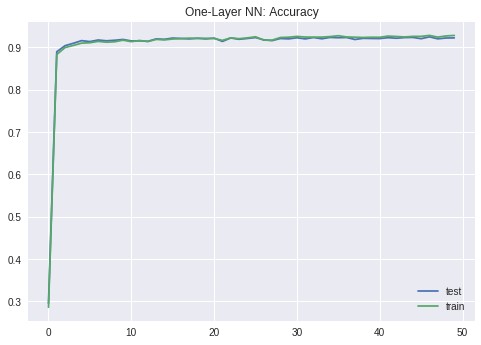

In [0]:
plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label= "train")
plt.title("One-Layer NN: Accuracy")
plt.legend()

Text(0.5,1,u'One-Layer NN: Cost')

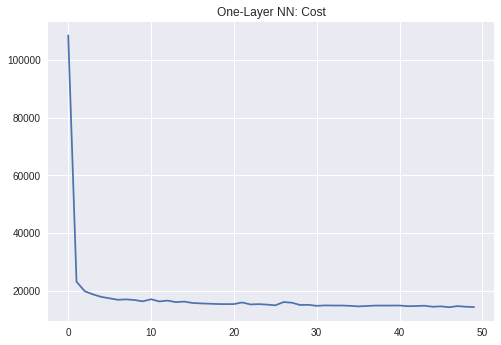

In [0]:
plt.plot(costs)
plt.title("One-Layer NN: Cost")

---
# 2. Add More Layers

<img src="figs/8-comic2.png" style="width: 500px;"/>

Now, let's improve the recognition accuracy by adding more layers to the neural network. The neurons in the second layer, instead of computing weighted sums of pixels will compute weighted sums of neuron outputs from the previous layer. We keep the softmax function as the activation function on the last layer, but on intermediate layers we will use the the **sigmoid** activation function. So, let's build a five-layer fully connected neural network with the following structure, and train the model with the trainging data and print out its accuracy on the test data.
<img src="figs/9-five_layer.png" style="width: 500px;"/>

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with five layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1 [200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2 [100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3 [60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4 [30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5 [10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
W1 = tf.Variable(tf.random_normal([784,200]))
B1 = tf.Variable(tf.zeros([200]))

W2 = tf.Variable(tf.random_normal([200,100]))
B2 = tf.Variable(tf.zeros([100]))

W3 = tf.Variable(tf.random_normal([100,60]))
B3 = tf.Variable(tf.zeros([60]))

W4 = tf.Variable(tf.random_normal([60,30]))
B4 = tf.Variable(tf.zeros([30]))

W5 = tf.Variable(tf.random_normal([30,10]))
B5 = tf.Variable(tf.zeros([10]))

########################################
# build the model
########################################
XX = tf.reshape(X,([-1,784]))

Y1_hat = tf.nn.sigmoid(tf.matmul(XX,W1) + B1)
Y2_hat = tf.nn.sigmoid(tf.matmul(Y1_hat,W2) + B2)
Y3_hat = tf.nn.sigmoid(tf.matmul(Y2_hat,W3) + B3)
Y4_hat = tf.nn.sigmoid(tf.matmul(Y3_hat,W4) + B4)
Y_hat = tf.nn.softmax(tf.matmul(Y4_hat,W5) + B5)

########################################
# define the cost function
########################################
cross_entropy = -tf.reduce_sum(Y*tf.log(Y_hat))

########################################
# define the optimizer
########################################
learning_rate = 0.005
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()
train_accuracies = []
test_accuracies = []
costs = []

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
      sess.run(train_step, {XX: batch_xs, Y: batch_ys})
      
      if n % 250 == 0:
        cost, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={XX: mnist.train.images, Y: mnist.train.labels})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels})
        print("current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
               
    print("----------------------------------------------")
    final_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels})
    print("Final Model Accuracy: {0} %".format(round(final_accuracy*100, 2)))
    print("Final Cost: {0}".format(round(cost,2)))

Iteration 0, cost is 228925.08
current Model Accuracy: 10.29 %
Iteration 250, cost is 50590.21
current Model Accuracy: 70.69 %
Iteration 500, cost is 34630.52
current Model Accuracy: 80.53 %
Iteration 750, cost is 28158.32
current Model Accuracy: 84.03 %
Iteration 1000, cost is 24054.4
current Model Accuracy: 86.14 %
Iteration 1250, cost is 21668.05
current Model Accuracy: 87.1 %
Iteration 1500, cost is 20555.13
current Model Accuracy: 87.5 %
Iteration 1750, cost is 17830.66
current Model Accuracy: 88.7 %
Iteration 2000, cost is 16755.77
current Model Accuracy: 89.37 %
Iteration 2250, cost is 15780.03
current Model Accuracy: 89.89 %
Iteration 2500, cost is 14556.1
current Model Accuracy: 90.19 %
Iteration 2750, cost is 13883.05
current Model Accuracy: 90.41 %
Iteration 3000, cost is 13036.91
current Model Accuracy: 90.7 %
Iteration 3250, cost is 12405.14
current Model Accuracy: 90.87 %
Iteration 3500, cost is 11852.19
current Model Accuracy: 90.96 %
Iteration 3750, cost is 11911.73
cur

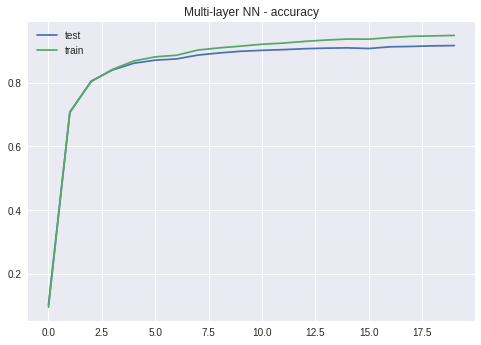

In [0]:
plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label = "train")
plt.title("Multi-layer NN - accuracy")
plt.legend()

Text(0.5,1,u'Multi-Layer NN: Cost')

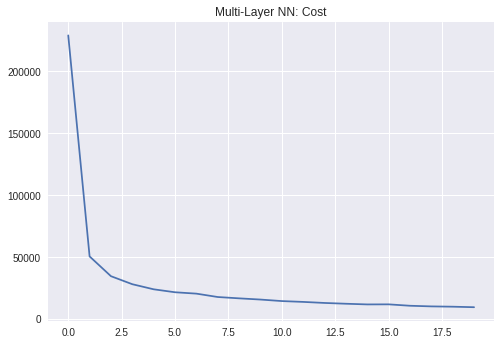

In [0]:
plt.plot(costs)
plt.title("Multi-Layer NN: Cost")

---
# 3. Special Care for Deep Networks
As layers were added, neural networks tended to converge with more difficulties. For example, the accuracy could stuck at 0.1. Here, we want to apply some updates to the network we built in the previous part to improve its performance. 

### ReLU Activation Function
<img src="figs/10-comic3.png" style="width: 500px;"/>
The sigmoid activation function is actually quite problematic in deep networks. It squashes all values between 0 and 1 and when you do so repeatedly, neuron outputs and their gradients can vanish entirely. An alternative activation function is **ReLU** that shows better performance compare to sigmoid. It looks like as below:
<img src="figs/11-relu.png" style="width: 300px;"/>

### A Better Optimizer
In very high dimensional spaces like here, **saddle points** are frequent. These are points that are not local minima, but where the gradient is nevertheless zero and the gradient descent optimizer stays stuck there. One possible solution to tackle this probelm is to use better optimizers, such as Adam optimizer `tf.train.AdamOptimizer`.

### Random Initialisations
When working with ReLUs, the best practice is to initialise bias values to small positive values, so that neurons operate in the non-zero range of the ReLU initially.

### Learning Rate
<img src="figs/12-comic4.png" style="width: 500px;"/>
With two, three or four intermediate layers, you can now get close to 98% accuracy, if you push the iterations to 5000 or beyond. But, the results are not very consistent, and the curves jump up and down by a whole percent. A good solution is to start fast and decay the learning rate exponentially from $0.005$ to $0.0001$ for example. In order to pass a different learning rate to the `AdamOptimizer` at each iteration, you will need to define a new placeholder and feed it a new value at each iteration through `feed_dict`. Here is the formula for exponential decay: $learning\_rate = lr\_min + (lr\_max - lr\_min) * e^{\frac{-i}{2000}}$, where $i$ is the iteration number.

### NaN?
In the network you built in the last section, you might see accuracy curve crashes and the console outputs NaN for the cross-entropy. It may happen, because you are attempting to compute a $log(0)$, which is indeed Not A Number (NaN). Remember that the cross-entropy involves a log, computed on the output of the softmax layer. Since softmax is essentially an exponential, which is never zero, we should be fine, but with 32 bit precision floating-point operations, exp(-100) is already a genuine zero. TensorFlow has a handy function that computes the softmax and the cross-entropy in a single step, implemented in a numerically stable way. To use it, you will need to separate the weighted sum plus bias on the last layer, before softmax is applied and then give it with the true values to the function `tf.nn.softmax_cross_entropy_with_logits`.

In the code below, apply the following changes and show their impact on the accuracy of the model on training data, as well as the test data:
* Replace the sigmoid activation function with ReLU
* Use the Adam optimizer
* Initialize weights with small random values between -0.2 and +0.2, and make sure biases are initialised with small positive values, for example 0.1
* Update the learning rate in different iterations. Start fast and decay the learning rate exponentially from $0.005$ to $0.0001$, i.e., 
```
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
```
* Use `tf.nn.softmax_cross_entropy_with_logits` to prevent getting NaN in output.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

# for useing the exponential function 
import math

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)
step = tf.placeholder(tf.float32)

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.2))
B1 = tf.Variable(tf.ones([200])/10)

W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.2))
B2 = tf.Variable(tf.ones([100])/10)

W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.2))
B3 = tf.Variable(tf.ones([60])/10)

W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.2))
B4 = tf.Variable(tf.ones([30])/10)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.2))
B5 = tf.Variable(tf.ones([10])/10)

########################################
# build the model
########################################
XX = tf.reshape(X,([-1,784]))

Y1_hat = tf.nn.relu(tf.matmul(XX,W1) + B1)
Y2_hat = tf.nn.relu(tf.matmul(Y1_hat,W2) + B2)
Y3_hat = tf.nn.relu(tf.matmul(Y2_hat,W3) + B3)
Y4_hat = tf.nn.relu(tf.matmul(Y3_hat,W4) + B4)
Ylogits = tf.matmul(Y4_hat,W5) + B5
Y_hat = tf.nn.softmax(Ylogits)

########################################
# defining the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define learning rate
########################################
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + tf.train.exponential_decay(max_learning_rate, step, decay_speed, 1/math.e)

########################################
# define the optimizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()
train_accuracy = []
test_accuracies = []
train_costs = []
test_costs = []
lrs = []

#accuracy
correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

#run model
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    
    for n in range(n_epochs):
      
      # training on batches of 100 images with 100 labels
      batch_xs, batch_ys = mnist.train.next_batch(100)     
      sess.run(train_step, {XX: batch_xs, Y: batch_ys, step: n})
      
      if n % 250 == 0:
        train_cost, lr, train_accuracy = sess.run([cross_entropy,learning_rate, accuracy], feed_dict={XX: mnist.train.images, Y: mnist.train.labels, step: n})
        print("Iteration {0}, cost is {1}".format(n, round(train_cost,2)))
        test_cost, test_accuracy = sess.run([cross_entropy,accuracy], feed_dict={XX: mnist.test.images, Y: mnist.test.labels, step: n})
        print("current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        train_costs.append(train_cost)
        test_costs.append(test_cost)
        lrs.append(lr)
               
    print("----------------------------------------------")
    print("Final Learning Rate:")
    print(round(lr,5))
    final_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels, step: n})
    print("Final Model Accuracy:")
    print(round(final_accuracy*100, 2))

Iteration 0, cost is 260.71
current Model Accuracy: 15.83 %
Iteration 250, cost is 17.25
current Model Accuracy: 94.49 %
Iteration 500, cost is 11.96
current Model Accuracy: 95.94 %
Iteration 750, cost is 9.25
current Model Accuracy: 96.35 %
Iteration 1000, cost is 7.41
current Model Accuracy: 96.81 %
Iteration 1250, cost is 5.56
current Model Accuracy: 97.31 %
Iteration 1500, cost is 5.99
current Model Accuracy: 96.91 %
Iteration 1750, cost is 4.21
current Model Accuracy: 97.28 %
Iteration 2000, cost is 3.61
current Model Accuracy: 97.22 %
Iteration 2250, cost is 2.52
current Model Accuracy: 97.59 %
Iteration 2500, cost is 2.2
current Model Accuracy: 97.57 %
Iteration 2750, cost is 2.01
current Model Accuracy: 97.63 %
Iteration 3000, cost is 1.2
current Model Accuracy: 97.78 %
Iteration 3250, cost is 1.04
current Model Accuracy: 97.91 %
Iteration 3500, cost is 0.81
current Model Accuracy: 97.67 %
Iteration 3750, cost is 0.67
current Model Accuracy: 97.96 %
Iteration 4000, cost is 0.42

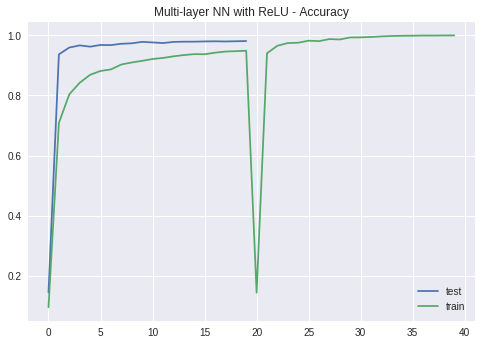

In [0]:
plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label = "train")
plt.title("Multi-layer NN with ReLU - Accuracy")
plt.legend()

Text(0.5,1,u'Multi-layer NN with ReLU - Learning rate')

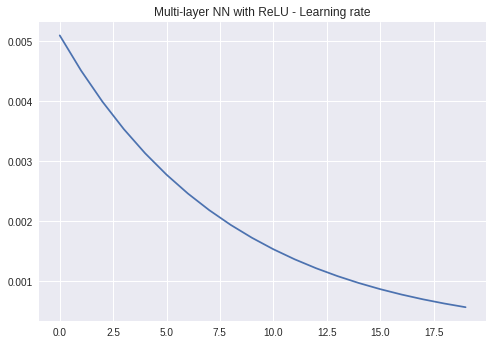

In [0]:
plt.plot(lrs)
plt.title("Multi-layer NN with ReLU - Learning rate")

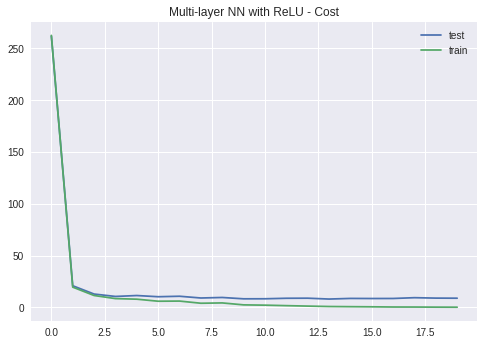

In [0]:
plt.plot(test_costs, label= "test")
plt.plot(train_costs, label = "train")
plt.title("Multi-layer NN with ReLU - Cost")
plt.legend()

---
# 4. Overfitting and Dropout
<img src="figs/13-comic5.png" style="width: 500px;"/>
You will have noticed that cross-entropy curves for test and training data start disconnecting after a couple thousand iterations. The learning algorithm works on training data only and optimises the training cross-entropy accordingly. It never sees test data so it is not surprising that after a while its work no longer has an effect on the test cross-entropy which stops dropping and sometimes even bounces back up. 
<img src="figs/14-overfit.png" style="width: 500px;"/>
This disconnect is usually labeled **overfitting** and when you see it, you can try to apply a regularisation technique called **dropout**. In dropout, at each training iteration, you drop random neurons from the network. You choose a probability `pkeep` for a neuron to be kept, usually between 50% and 75%, and then at each iteration of the training loop, you randomly remove neurons with all their weights and biases. Different neurons will be dropped at each iteration. When testing the performance of your network of course you put all the neurons back (`pkeep = 1`).
<img src="figs/15-dropout.png" style="width: 500px;"/>
TensorFlow offers a dropout function to be used on the outputs of a layer of neurons. It randomly zeroes-out some of the outputs and boosts the remaining ones by `1 / pkeep`. You can add dropout after each intermediate layer in the network now. 

In the following code, use the dropout between each layer during the training, and set the probability `pkeep` once to $50%$ and another time to $75%$ and compare their results.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)
step = tf.placeholder(tf.float32)

# probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32, shape=[])

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.2))
B1 = tf.Variable(tf.ones([200])/10)

W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.2))
B2 = tf.Variable(tf.ones([100])/10)

W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.2))
B3 = tf.Variable(tf.ones([60])/10)

W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.2))
B4 = tf.Variable(tf.ones([30])/10)

W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.2))
B5 = tf.Variable(tf.ones([10])/10)

########################################
# build the model
########################################
XX = tf.reshape(X,([-1,784]))

Y1_hat = tf.nn.relu(tf.matmul(XX,W1) + B1)
Y1_hat_dropout = tf.nn.dropout(Y1_hat, keep_prob=pkeep)
Y2_hat_dropout = tf.nn.dropout(tf.nn.relu(tf.matmul(Y1_hat_dropout, W2) + B2), keep_prob=pkeep)
Y3_hat_dropout = tf.nn.dropout(tf.nn.relu(tf.matmul(Y2_hat_dropout, W3) + B3), keep_prob=pkeep)
Y4_hat_dropout = tf.nn.dropout(tf.nn.relu(tf.matmul(Y3_hat_dropout, W4) + B4), keep_prob=pkeep)
Ylogits = tf.matmul(Y4_hat_dropout,W5) + B5
Y_hat = tf.nn.softmax(Ylogits)

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define learning rate
########################################
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + tf.train.exponential_decay(max_learning_rate, step, decay_speed, 1/math.e)

########################################
# define the optimizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

test_accuracies = {'0.5': [],'0.75': []}
costs = {'0.5': [], '0.75': []}
lrs = {'0.5': [], '0.75': []}

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

n_epochs = 5000
for dropout in [0.5, 0.75]:
  print("----------------------------------------------")
  print("DROPOUT APPLIED:")
  print(dropout)
  
  with tf.Session() as sess:
    sess.run(init)
    
    for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
        
      sess.run(train_step, {XX: batch_xs, Y: batch_ys, step:n, pkeep: dropout})
      
      #get test data accuracy
      if n % 250 == 0:
        cost, lr = sess.run([cross_entropy,learning_rate], feed_dict={XX: mnist.train.images, Y: mnist.train.labels, step:n, pkeep: 1.0})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels, step:n, pkeep: 1.0})
        print("current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        test_accuracies[str(dropout)].append(test_accuracy)
        costs[str(dropout)].append(cost)
        lrs[str(dropout)].append(lr)
               
    print("----------------------------------------------")
    final_accuracy = sess.run(accuracy, feed_dict={XX: mnist.test.images, Y: mnist.test.labels, step:n, pkeep: 1.0})
    print("Final Model Accuracy:")
    print(round(final_accuracy*100, 2))
    print("----------------------------------------------")

----------------------------------------------
DROPOUT APPLIED:
0.5
Iteration 0, cost is 322.09
current Model Accuracy: 10.82 %
Iteration 250, cost is 128.69
current Model Accuracy: 48.55 %
Iteration 500, cost is 73.3
current Model Accuracy: 80.31 %
Iteration 750, cost is 48.57
current Model Accuracy: 89.3 %
Iteration 1000, cost is 37.84
current Model Accuracy: 91.39 %
Iteration 1250, cost is 33.05
current Model Accuracy: 92.15 %
Iteration 1500, cost is 29.8
current Model Accuracy: 92.96 %
Iteration 1750, cost is 27.1
current Model Accuracy: 92.79 %
Iteration 2000, cost is 25.12
current Model Accuracy: 93.62 %
Iteration 2250, cost is 24.85
current Model Accuracy: 93.86 %
Iteration 2500, cost is 23.11
current Model Accuracy: 93.7 %
Iteration 2750, cost is 20.99
current Model Accuracy: 94.3 %
Iteration 3000, cost is 20.6
current Model Accuracy: 94.43 %
Iteration 3250, cost is 19.41
current Model Accuracy: 94.69 %
Iteration 3500, cost is 19.25
current Model Accuracy: 94.81 %
Iteration 375

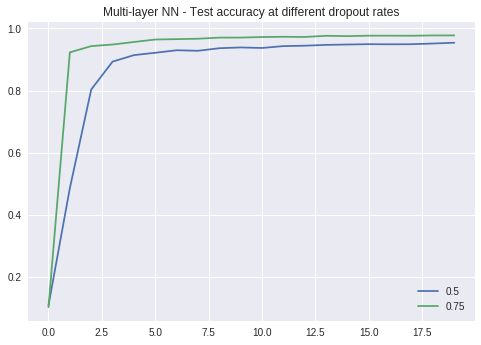

In [0]:
plt.plot(test_accuracies["0.5"],label="0.5")
plt.plot(test_accuracies["0.75"],label="0.75")
plt.title("Multi-layer NN - Test accuracy at different dropout rates")
plt.legend()

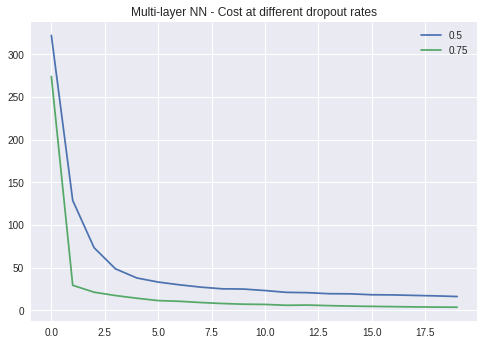

In [0]:
plt.plot(costs['0.5'],label="0.5")
plt.plot(costs['0.75'],label="0.75")
plt.title("Multi-layer NN - Cost at different dropout rates")
plt.legend()

---
# 6. Convolutional Network
<img src="figs/16-comic6.png" style="width: 500px;"/>
In the previous sections, all pixels of images flattened into a single vector, which was a really bad idea. Handwritten digits are made of shapes and we discarded the shape information when we flattened the pixels. However, we can use **convolutional neural networks (CNN)** to take advantage of shape information. CNNs apply *a series of filters* to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:
  - **Convolutional layers**: apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.
  - **Pooling layers**: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.
  - **Dense (fully connected) layers**: perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.
  
Typically, a CNN is composed of a *stack of **convolutional modules*** that perform feature extraction. Each *module* consists of a *convolutional layer* followed by a *pooling layer*. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single neuron for each target class in the model, with a softmax activation function to generate a value between 0-1 for each neuron. We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.

Now, let us build a convolutional network for handwritten digit recognition. In this assignment, we will use the architecture shown in the following figure that has three convolutional layers, one fully-connected layer, and one softmax layer. Notice that the second and third convolutional layers have a stride of two that explains why they bring the number of output values down from 28x28 to 14x14 and then 7x7. A convolutional layer requires a weights tensor like `[4, 4, 3, 2]`, in which the first two numbers define the size of a filter (map), the third number shows the *depth* of the filter that is the number of *input channel*, and the last number shows the number of *output channel*. The output channel defines the number of times that we repeat the same thing with a different set of weights in one layer. In our implementation, we assume the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected layer is 200.
<img src="figs/17-arch1.png" style="width: 600px;"/>

Convolutional layers can be implemented in TensorFlow using the `tf.nn.conv2d` function, which performs the scanning of the input image in both directions using the supplied weights. This is only the weighted sum part of the neuron. You still need to add a bias and feed the result through an activation function. The padding strategy that works here is to copy pixels from the sides of the image. All digits are on a uniform background so this just extends the background and should not add any unwanted shapes.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·      (input data, 1-deep)               X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 5x5x1=>4 stride 1      W1 [5, 5, 1, 4]        B1 [4]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 4]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x4=>8 stride 2      W2 [5, 5, 4, 8]        B2 [8]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 8]
#     @ @ @ @ @ @       -- conv. layer 4x4x8=>12 stride 2     W3 [4, 4, 8, 12]       B3 [12]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 12] => reshaped to YY [batch, 7*7*12]
#      \x/x\x\x/        -- fully connected layer (relu)       W4 [7*7*12, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)    W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 784])
XX = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)
step = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200
W1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 4],stddev=0.2))
B1 = tf.Variable(tf.ones([4])/10)

W2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 4, 8],stddev=0.2))
B2 = tf.Variable(tf.ones([8])/10)

W3 = tf.Variable(tf.truncated_normal(shape=[4, 4, 8, 12],stddev=0.2))
B3 = tf.Variable(tf.ones([12])/10)

W4 = tf.Variable(tf.truncated_normal(shape=[7*7*12, 200],stddev=0.2))
B4 = tf.Variable(tf.ones([200])/10)

W5 = tf.Variable(tf.truncated_normal(shape=[200, 10],stddev=0.2))
B5 = tf.Variable(tf.ones([10])/10)

########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(XX, W1, strides=[1, stride, stride, 1], padding = "SAME") + B1)       # use tf.nn.conv2d

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat, W2, strides=[1, stride, stride, 1], padding = "SAME") + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat, W3, strides=[1, stride, stride, 1], padding = "SAME") + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, [-1, 7*7*12])
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
Ylogits = tf.matmul(Y4_hat,W5) + B5
Y_hat = tf.nn.softmax(Ylogits)

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define learning rate
########################################
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + tf.train.exponential_decay(max_learning_rate, step, decay_speed, 1/math.e)

########################################
# define the optmizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_accuracies = []
test_accuracies = []
costs = []

n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    
    for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
        
      sess.run(train_step, {X: batch_xs, Y: batch_ys, step:n})
      
      #get test data accuracy
      if n % 250 == 0:
        cost, train_accuracy = sess.run([cross_entropy,accuracy], feed_dict={X: mnist.train.images, Y: mnist.train.labels, step:n})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, step:n})
        print("Current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
        
    print("----------------------------------------------")
    final_accuracy,final_lr = sess.run([accuracy, learning_rate], feed_dict={X: mnist.test.images, Y: mnist.test.labels, step: n})
    print("Final Model Accuracy:{0}\n Final Learning Rate:{1}".format(round(final_accuracy*100, 2), round(final_lr,5)))
    print("----------------------------------------------")

Iteration 0, cost is 635.17
Current Model Accuracy: 11.81 %
Iteration 250, cost is 11.51
Current Model Accuracy: 96.53 %
Iteration 500, cost is 7.66
Current Model Accuracy: 97.24 %
Iteration 750, cost is 5.61
Current Model Accuracy: 97.98 %
Iteration 1000, cost is 4.22
Current Model Accuracy: 98.1 %
Iteration 1250, cost is 3.97
Current Model Accuracy: 98.27 %
Iteration 1500, cost is 2.64
Current Model Accuracy: 98.47 %
Iteration 1750, cost is 2.41
Current Model Accuracy: 98.39 %
Iteration 2000, cost is 1.84
Current Model Accuracy: 98.45 %
Iteration 2250, cost is 1.99
Current Model Accuracy: 98.44 %
Iteration 2500, cost is 1.85
Current Model Accuracy: 98.3 %
Iteration 2750, cost is 1.05
Current Model Accuracy: 98.64 %
Iteration 3000, cost is 0.95
Current Model Accuracy: 98.61 %
Iteration 3250, cost is 0.49
Current Model Accuracy: 98.73 %
Iteration 3500, cost is 0.47
Current Model Accuracy: 98.7 %
Iteration 3750, cost is 0.33
Current Model Accuracy: 98.69 %
Iteration 4000, cost is 0.32
C

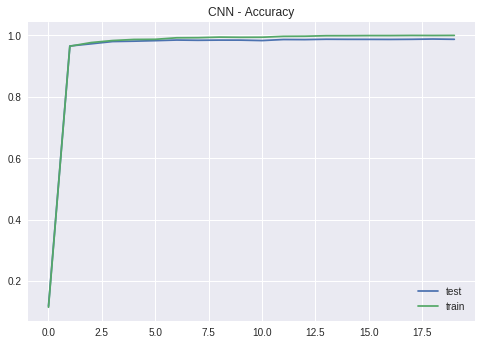

In [0]:
plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label = "train")
plt.title("CNN - Accuracy")
plt.legend()

Text(0.5,1,u'CNN - cost')

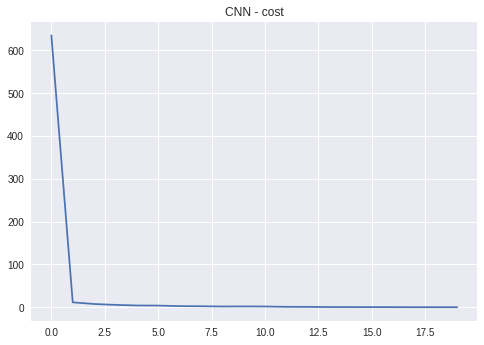

In [0]:
plt.plot(costs)
plt.title("CNN - cost")

# 7. Improve The Performance
A good approach to sizing your neural networks is to implement a network that is a little too constrained, then give it a bit more degrees of freedom and add dropout to make sure it is not overfitting. This ends up with a fairly optimal network for your problem. In the above model, we set the output channel to 4 in the first convolutional layer, which means that we repeat the same filter shape (but with different weights) four times. If we assume that those filters evolve during training into shape recognisers, you can intuitively see that this might not be enough for our problem. Handwritten digits are made from more than 4 elemental shapes. So let us bump up the filter sizes a little, and also increase the number of filters in our convolutional layers from 4, 8, 12 to 6, 12, 24 and then add dropout on the fully-connected layer. The following figure shows the new architecture you should build. Please complete the following code based on the given architecture and dropout technique.
<img src="figs/18-arch2.png" style="width: 600px;"/>

In [0]:
# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 784])
XX = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)
step = tf.placeholder(tf.float32)

#dropout rate
pkeep = tf.placeholder(tf.float32)

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 6, 12, 24, and the size of fully connected
# layer is 200
W1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 6],stddev=0.1))
B1 = tf.Variable(tf.ones([6])/10)

W2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 6, 12],stddev=0.1))
B2 = tf.Variable(tf.ones([12])/10)

W3 = tf.Variable(tf.truncated_normal(shape=[4, 4, 12, 24],stddev=0.1))
B3 = tf.Variable(tf.ones([24])/10)

W4 = tf.Variable(tf.truncated_normal(shape=[7*7*24, 200],stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

W5 = tf.Variable(tf.truncated_normal(shape=[200, 10],stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

########################################
# build the model
########################################
stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(XX, W1, strides=[1, stride, stride, 1], padding = "SAME") + B1)

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat, W2, strides=[1, stride, stride, 1], padding = "SAME") + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat, W3, strides=[1, stride, stride, 1], padding = "SAME") + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, [-1, 7*7*24])
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
YY4_hat = tf.nn.dropout(Y4_hat, keep_prob=pkeep)
Ylogits = tf.matmul(YY4_hat,W5) + B5
Y_hat = tf.nn.softmax(Ylogits)

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define learning rate
########################################
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + tf.train.exponential_decay(max_learning_rate, step, decay_speed, 1/math.e)

########################################
# train the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_accuracies = []
test_accuracies = []
costs = []
droupout = 0.7       #since 0.7 showed best results after tryout

n_epochs = 2000
with tf.Session() as sess:
  sess.run(init)
  
  for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
        
      sess.run(train_step, {X: batch_xs, Y: batch_ys, step:n, pkeep: dropout})
      
      #get test data accuracy
      if n % 200 == 0:
        cost, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={X: mnist.train.images, Y: mnist.train.labels, step:n, pkeep:1.0})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, step:n, pkeep:1.0})
        print("Current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
               
  print("----------------------------------------------")
  final_accuracy,final_lr = sess.run([accuracy, learning_rate], feed_dict={X: mnist.test.images, Y: mnist.test.labels, step: n, pkeep:1.0})
  print("Final Model Accuracy:{0}\n Final Learning Rate:{1}".format(round(final_accuracy*100, 2), final_lr))
  print("----------------------------------------------")

Iteration 0, cost is 293.36
Current Model Accuracy: 15.89 %
Iteration 200, cost is 10.99
Current Model Accuracy: 96.54 %
Iteration 400, cost is 6.62
Current Model Accuracy: 97.85 %
Iteration 600, cost is 5.55
Current Model Accuracy: 98.18 %
Iteration 800, cost is 4.04
Current Model Accuracy: 98.33 %
Iteration 1000, cost is 3.06
Current Model Accuracy: 98.79 %
Iteration 1200, cost is 2.86
Current Model Accuracy: 98.82 %
Iteration 1400, cost is 2.28
Current Model Accuracy: 98.98 %
Iteration 1600, cost is 2.05
Current Model Accuracy: 98.89 %
Iteration 1800, cost is 1.69
Current Model Accuracy: 99.09 %
----------------------------------------------
Final Model Accuracy:99.07
 Final Learning Rate:0.00194031698629
----------------------------------------------


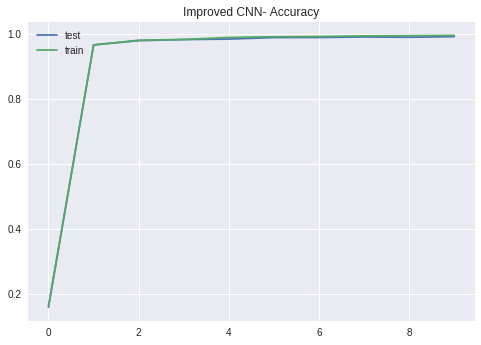

In [0]:
plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label = "train")
plt.title("Improved CNN- Accuracy")
plt.legend()

---
# 8. Tensorflow Layers Module
The TensorFlow **layers** `tf.layers` module provides a high-level API that makes it easy to construct a neural network. It provides methods that facilitate: (i) the creation of dense (fully connected) layers and convolutional layers, (ii) adding activation functions, and (iii) applying dropout regularization. In this section use the module `tf.layers` to build the network you made in section 7.

In [0]:
# TODO: Replace <FILL IN> with appropriate code

# to reset the Tensorflow default graph
reset_graph()

# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [5, 5, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]


########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, shape=[None, 784])
XX = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(tf.float32, shape=[None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32)
step = tf.placeholder(tf.float32)

#dropout rate
pkeep = tf.placeholder(tf.float32)


# Convolutional Layer #1
stride = 1
Y1_hat = tf.layers.conv2d(
      inputs=XX,
      filters=6,
      kernel_size=[5, 5],
      strides = (stride, stride),
      use_bias=True,
      padding="same",
      activation=tf.nn.relu)

# Convolutional Layer #2
stride = 2
Y2_hat = tf.layers.conv2d(
      inputs=Y1_hat,
      filters=12,
      kernel_size=[5, 5],
      strides = (stride, stride),
      use_bias=True,
      padding="same",
      activation=tf.nn.relu)

# Convolutional Layer #3
stride = 2
Y3_hat = tf.layers.conv2d(
      inputs=Y2_hat,
      filters=24,
      kernel_size=[4, 4],
      strides = (stride, stride),
      use_bias=True,
      padding="same",
      activation=tf.nn.relu)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat, [-1, 7*7*24])

Y4_hat = tf.layers.dense(inputs=YY_hat,
                        units= 200,
                        use_bias=True,
                        activation=tf.nn.relu)

Y4_dropout = tf.layers.dropout(inputs=Y4_hat,
                            rate=(1-pkeep))

Ylogits = tf.layers.dense(inputs=Y4_dropout, units=10)
Y_hat = tf.nn.softmax(Ylogits)

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define learning rate
########################################
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
learning_rate = min_learning_rate + tf.train.exponential_decay(max_learning_rate, step, decay_speed, 1/math.e)

########################################
# train the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_accuracies = []
test_accuracies = []
costs = []
droupout = 0.7       #since 0.75 showed best results before

n_epochs = 2000
with tf.Session() as sess:
  sess.run(init)
  
  for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
        
      sess.run(train_step, {X: batch_xs, Y: batch_ys, step:n, pkeep: dropout})
      
      #get test data accuracy
      if n % 200 == 0:
        cost, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={X: mnist.train.images, Y: mnist.train.labels, step:n, pkeep:1.0})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, step:n, pkeep:1.0})
        print("Current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
               
  print("----------------------------------------------")
  final_accuracy,final_lr = sess.run([accuracy, learning_rate], feed_dict={X: mnist.test.images, Y: mnist.test.labels, step: n, pkeep:1.0})
  print("Final Model Accuracy:{0}\n Final Learning Rate:{1}".format(round(final_accuracy*100, 2), final_lr))
  print("----------------------------------------------")

Iteration 0, cost is 223.21
Current Model Accuracy: 28.75 %
Iteration 200, cost is 8.78
Current Model Accuracy: 97.32 %
Iteration 400, cost is 6.95
Current Model Accuracy: 97.8 %
Iteration 600, cost is 4.98
Current Model Accuracy: 98.27 %
Iteration 800, cost is 4.05
Current Model Accuracy: 98.37 %
Iteration 1000, cost is 2.52
Current Model Accuracy: 98.82 %
Iteration 1200, cost is 2.62
Current Model Accuracy: 98.68 %
Iteration 1400, cost is 2.89
Current Model Accuracy: 98.51 %
Iteration 1600, cost is 2.01
Current Model Accuracy: 98.67 %
Iteration 1800, cost is 1.53
Current Model Accuracy: 98.89 %
----------------------------------------------
Final Model Accuracy:98.98
 Final Learning Rate:0.00194031698629
----------------------------------------------


---
# 9. Keras
Keras is a high-level API to build and train deep learning models. It's used for fast prototyping, advanced research, and production. `tf.keras` is TensorFlow's implementation of the Keras API specification. To work with Keras, you need to import `tf.keras` as part of your TensorFlow program setup.
```
import tensorflow as tf
from tensorflow.keras import layers
```
#### Build a model
In Keras, you assemble **layers** to build a model, i.e., a graph of layers. The most common type of model is a stack of layers: the `tf.keras.Sequential` model. For example, the following code builds a simple, fully-connected network (i.e., multi-layer perceptron):
```
model = tf.keras.Sequential()
# adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# add another
model.add(layers.Dense(64, activation='relu'))
# add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))
```
There are many `tf.keras.layers` available with some common constructor parameters:
* `activation`: set the activation function for the layer, which is specified by the name of a built-in function or as a callable object.
* `kernel_initializer` and `bias_initializer`: the initialization schemes that create the layer's weights (weight and bias).
* `kernel_regularizer` and `bias_regularizer`: the regularization schemes that apply the layer's weights (weight and bias), such as L1 or L2 regularization.

#### Train and evaluate
After you construct a model, you can configure its learning process by calling the `compile` method:
```
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
```
The method `tf.keras.Model.compile` takes three important arguments:
* `optimizer`: it specifies the training procedure, e.g., `tf.train.AdamOptimizer` and `tf.train.GradientDescentOptimizer`.
* `loss`: the cost function to minimize during optimization, e.g., mean square error (mse), categorical_crossentropy, and binary_crossentropy.
* `metrics`: used to monitor training, e.g., `accuracy`.

The next step after confiuring the model is to train it by calling the `model.fit` method and giving it training data as its input. After training the model you can call `tf.keras.Model.evaluate` and `tf.keras.Model.predict` methods to evaluate the inference-mode loss and metrics for the data provided or predict the output of the last layer in inference for the data provided, respectively.

You can read more about Keras [here](https://www.tensorflow.org/guide/keras).

In this task, please use Keras to rebuild the network you made in section 7.

In [0]:
reset_graph()

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras import backend as K

K.clear_session() #Destroys the current TF graph and creates a new one.


(X_train_tmp, Y_train), (X_test_tmp, Y_test) = mnist.load_data() #Loading the data

X_train = X_train_tmp.reshape(-1, 28, 28, 1)
X_test = X_test_tmp.reshape(-1, 28, 28, 1)

Y_train_cat = keras.utils.to_categorical(Y_train, 10)
Y_test_cat = keras.utils.to_categorical(Y_test, 10)

model = Sequential() #Choose model for keras

weights_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None) #Same as question 7

bias_initializer = keras.initializers.Constant(value=0.1) #Same

#Adding the different Conv

model.add(Conv2D(filters=6, kernel_size=(5, 5), kernel_initializer = weights_initializer, bias_initializer = bias_initializer, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)))

model.add(Conv2D(filters=12, kernel_size=(5, 5), kernel_initializer = weights_initializer, bias_initializer = bias_initializer, strides=2, padding='same', activation='relu', input_shape=(28, 28, 6)))

model.add(Conv2D(filters=24, kernel_size=(4, 4), kernel_initializer = weights_initializer, bias_initializer = bias_initializer, strides=2, padding='same', activation='relu', input_shape=(14, 14, 12)))
 
model.add(Flatten())

model.add(Dense(200, kernel_initializer = weights_initializer, bias_initializer = bias_initializer, activation='relu'))

model.add(Dropout(0.7))

model.add(Dense(10, kernel_initializer = weights_initializer, bias_initializer = bias_initializer, activation='softmax'))

#Compiling the model with AdamOptimizer like before

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

#Model fitting

history = model.fit(X_train, 
          Y_train_cat,
          batch_size=100,
          epochs=12,
          verbose=1,
          validation_data=(X_test, Y_test_cat)
         )

#Test

test_set_accuracy = model.evaluate(X_test, Y_test_cat, verbose=0)
print('Test accuracy:', round(test_set_accuracy[1]*100,2))
print('Test Loss:', round(test_set_accuracy[0],2))


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 63s 1ms/step - loss: 3.7925 - acc: 0.6786 - val_loss: 0.2793 - val_acc: 0.9230
Epoch 2/12
60000/60000 [==============================] - 63s 1ms/step - loss: 0.4498 - acc: 0.8756 - val_loss: 0.1522 - val_acc: 0.9550
Epoch 3/12
60000/60000 [==============================] - 63s 1ms/step - loss: 0.2994 - acc: 0.9135 - val_loss: 0.1153 - val_acc: 0.9627
Epoch 4/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.2237 - acc: 0.9344 - val_loss: 0.0963 - val_acc: 0.9720
Epoch 5/12
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1869 - acc: 0.9454 - val_loss: 0.0811 - val_acc: 0.9747
Epoch 6/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1587 - acc: 0.9536 - val_loss: 0.0729 - val_acc: 0.9772
Epoch 7/12
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1388 - acc: 0.9593 - val_loss: 0.0672 - val_acc

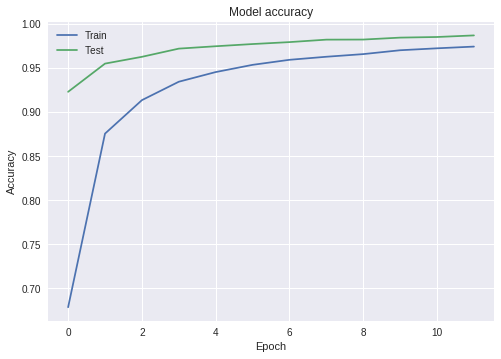

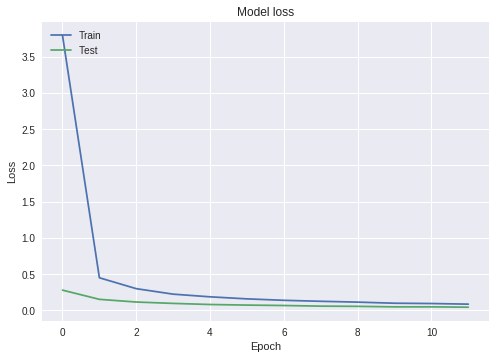

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

---
# 10. Implement LeNet-5
In this section, you should implement **LeNet-5** either using Tensorflow or Keras. Please take a look at its [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) before starting to implement it.
The LeNet-5 architecture is perhaps the most widely known CNN architecture. It was created by Yann LeCun in 1998 and widely used for handwritten digit recognition (MNIST). It is composed of the layers shown in the following table.
<img src="figs/19-letnet5.png" style="width: 600px;"/>
There are a few extra details to be noted:
* MNIST images are 28×28 pixels, but they are zero-padded to 32×32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient and adds a learnable bias term, then finally applies the activation function.
* Most neurons in layer C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) for details.
* The output layer is a bit special: instead of computing the dot product of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and thus converging faster.

In [0]:
# TODO: Build the LetNet-5 model, and test it on MNIST
#Use of TENSORFLOW since it showed the highest results until now

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(np.float32, shape=[None, 784])
XX = tf.reshape(X, [-1, 28, 28, 1])
Y = tf.placeholder(np.float32, shape=[None, 10])

# variable learning rate
learning_rate = 0.001

########################################
#LeNet 5 Model Implementation
########################################

def LeNet_5(x):
  
  #Convert data to 32x32x1 by numpy padding
  X_pad = tf.pad(x, [[0,0],[2,2],[2,2],[0,0]], 'CONSTANT')
  
 # Layer 1 : Convolutional Layer, Input = 32x32x1, Output = 28x28x1.
  W1 = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = 0, stddev = 0.1))
  B1 = tf.Variable(tf.ones([6])/10)
  C1 = tf.nn.conv2d(X_pad,W1, strides = [1,1,1,1], padding = 'VALID') + B1 
  
  C1 = tf.math.tanh(C1)
 
 # Pooling Layer, Input = 28x28x1. Output = 14x14x6.
  S2 = tf.nn.max_pool(C1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
 
 # Layer 2: Convolutional Layer, Output = 10x10x16.
  W3 = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = 0, stddev = 0.1))
  B3 = tf.Variable(tf.ones(16)/10)
  C3 = tf.nn.conv2d(S2, W3, strides = [1,1,1,1], padding = 'VALID') + B3
  
  C3 = tf.math.tanh(C3)
  
 # Pooling Layer, Input = 10x10x16. Output = 5x5x16.
  S4 = tf.nn.max_pool(C3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
  
 # Flatten, Input = 5x5x16. Output = 400.
  C5_flat = tf.reshape(S4, [-1,5*5*16])
  
 # Layer 3: Convolutional Layer, Output = 1x1x120.
  W5 = tf.Variable(tf.truncated_normal(shape = [400, 120], mean = 0, stddev = 0.1))
  B5 = tf.Variable(tf.ones(120)/10)
  C5 = tf.matmul(C5_flat,W5) + B5
 
  C5 = tf.math.tanh(C5)

 # Layer 4: Fully Connected, Input = 120. Output = 84.
  W6 = tf.Variable(tf.truncated_normal(shape = (120,84), mean = 0, stddev = 0.1))
  B6 = tf.Variable(tf.zeros(84))
  F6 = tf.matmul(C5,W6) + B6

  F6 = tf.math.tanh(F6)

 # Layer 5: Fully Connected, Input = 84. Output = 10.
  W7 = tf.Variable(tf.truncated_normal(shape = (84,10), mean = 0 , stddev = 0.1))
  B7 = tf.Variable(tf.zeros(10))
  out = tf.matmul(F6, W7) + B7
  out = tf.nn.softmax(out)
  return out

Ylogits = LeNet_5(XX)

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# train the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(Ylogits,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

train_accuracies = []
test_accuracies = []
costs = []
droupout = 0.7       #since 0.7 showed best results after tryout

n_epochs = 4000
with tf.Session() as sess:
  sess.run(init)
  
  for n in range(n_epochs):
      batch_xs, batch_ys = mnist.train.next_batch(100)
        
      sess.run(train_step, {X: batch_xs, Y: batch_ys})
      
      #get test data accuracy
      if n % 200 == 0:
        cost, train_accuracy = sess.run([cross_entropy, accuracy], feed_dict={X: mnist.train.images, Y: mnist.train.labels})
        print("Iteration {0}, cost is {1}".format(n, round(cost,2)))
        test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
        print("Current Model Accuracy: {0} %".format(round(test_accuracy*100, 2)))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        costs.append(cost)
               
  print("----------------------------------------------")
  final_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels})
  print("Final Model Accuracy:{0}".format(round(final_accuracy*100, 2)))
  print("----------------------------------------------")

Iteration 0, cost is 230.31
Current Model Accuracy: 9.59 %
Iteration 200, cost is 154.76
Current Model Accuracy: 93.79 %
Iteration 400, cost is 151.25
Current Model Accuracy: 96.07 %
Iteration 600, cost is 149.59
Current Model Accuracy: 97.18 %
Iteration 800, cost is 149.09
Current Model Accuracy: 97.43 %
Iteration 1000, cost is 148.54
Current Model Accuracy: 97.82 %
Iteration 1200, cost is 148.39
Current Model Accuracy: 97.73 %
Iteration 1400, cost is 148.24
Current Model Accuracy: 97.85 %
Iteration 1600, cost is 147.96
Current Model Accuracy: 98.08 %
Iteration 1800, cost is 147.8
Current Model Accuracy: 98.11 %
Iteration 2000, cost is 147.47
Current Model Accuracy: 98.34 %
Iteration 2200, cost is 147.45
Current Model Accuracy: 98.4 %
Iteration 2400, cost is 147.55
Current Model Accuracy: 98.28 %
Iteration 2600, cost is 147.22
Current Model Accuracy: 98.48 %
Iteration 2800, cost is 147.2
Current Model Accuracy: 98.52 %
Iteration 3000, cost is 147.03
Current Model Accuracy: 98.62 %
Ite

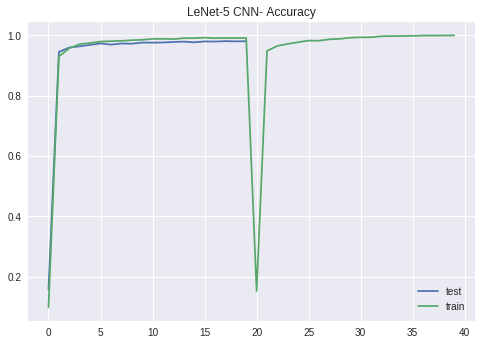

In [0]:
from matplotlib import pyplot as plt

plt.plot(test_accuracies, label= "test")
plt.plot(train_accuracies, label = "train")
plt.title("LeNet-5 CNN- Accuracy")
plt.legend()

---
# 11. Implement AlexNet
In the last section, you should implement **AlexNet** either using Tensorflow or Keras. Again, please take a look at its [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) before start to implement it.
The AlexNet CNN architecture won the [ImageNet ILSVRC challenge](http://www.image-net.org/challenges/LSVRC/2012/) in 2012 by a large margin. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The following table presents this architecture.
<img src="figs/20-alexnet.png" style="width: 600px;"/>
To train the model, we need a big dataset, however, in this assignment you are going to to assign the pretrained weights to your model, using `tf.Variable.assign`. You can download the pretrained weights from [bvlc_alexnet.npy](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy). This file is a NumPy array file created by the python. After you read this file, you will receive a python dictionary with a <key, value> pair for each layer. Each key is one of the layers names, e.g., `conv1`, and each value is a list of two values: (1) weights, and (2) biases of that layer. Part of the function to load the weights and biases to your model is given, and you need to complete it.

Here is what you see if you read and print the shape of each layer from the file:
```
weight_dic = np.load("bvlc_alexnet.npy", encoding="bytes").item()
for layer in weights_dic:
    print("-" * 20)
    print(layer)
    for wb in weights_dic[layer]:
        print(wb.shape)

#--------------------
# fc8
# (4096, 1000) # weights
# (1000,) # bias
#--------------------
# fc7
# (4096, 4096) # weights
# (4096,) # bias
#--------------------
# fc6
# (9216, 4096) # weights
# (4096,) # bias
#--------------------
# conv5
# (3, 3, 192, 256) # weights
# (256,) # bias
#--------------------
# conv4
# (3, 3, 192, 384) # weights
# (384,) # bias
#--------------------
# conv3
# (3, 3, 256, 384) # weights
# (384,) # bias
#--------------------
# conv2
# (5, 5, 48, 256) # weights
# (256,) # bias
#--------------------
# conv1
# (11, 11, 3, 96) # weights
# (96,) # bias
```


In [0]:
weight_dict = np.load("bvlc_alexnet.npy", encoding="bytes").item()
for layer in weight_dict:
    print("-" * 20)
    print(layer)
    print(weight_dict[layer][0].shape)
    print(weight_dict[layer][1].shape)

--------------------
fc6
(9216, 4096)
(4096,)
--------------------
fc7
(4096, 4096)
(4096,)
--------------------
fc8
(4096, 1000)
(1000,)
--------------------
conv3
(3, 3, 256, 384)
(384,)
--------------------
conv2
(5, 5, 48, 256)
(256,)
--------------------
conv1
(11, 11, 3, 96)
(96,)
--------------------
conv5
(3, 3, 192, 256)
(256,)
--------------------
conv4
(3, 3, 192, 384)
(384,)


In [0]:
import tensorflow as tf
reset_graph()

#using a class AlexNet to call it for each image


class AlexNet(object):
    def __init__(self):
      self.input_X = tf.placeholder(tf.float32, [None, 227, 227, 3])
      
      #There is a function for each step of AlexNet to not duplicate and copy paste each steps
        
    def convolutional_layer(self, inputs, shape, stride, name):
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:

            weights = tf.get_variable('weights', shape=shape)
            biases = tf.get_variable('biases', shape=shape[3])

        if name in ['conv2', 'conv4', 'conv5']:
            
            
            #List of different inputs
            input_groups = tf.split(axis=3, num_or_size_splits=2, value=inputs)
            
            #List of different weights
            weight_groups = tf.split(axis=3, num_or_size_splits=2, value=weights)
            
            #Creating the different conv nets with conv2D
            
            conv_nets = [tf.nn.conv2d(i, k, strides=[1, stride, stride, 1], padding='SAME') for i, k in zip(input_groups, weight_groups)]

            # Concatenation of the convolved output together
            
            conv = tf.concat(axis=3, values=conv_nets)

            return tf.nn.relu(tf.add(conv, biases), name=name)
        
        else:
            
            return tf.nn.relu(tf.add(tf.nn.conv2d(inputs, weights, strides=[1, stride, stride, 1], padding='SAME'), biases), name=name)
        
        
    #Creation of the different conv
    
    def conv(self, x, filter_height, filter_width, num_filters, stride_y, stride_x, name,
         padding='SAME', groups=1):

        # Number of input channels
        
        input_channels = int(x.get_shape()[-1])

        # Function for the convolution
        
        convolve = lambda i, k: tf.nn.conv2d(i, k,
                                             strides=[1, stride_y, stride_x, 1],
                                             padding=padding)

        with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:
          
            # Create tf variables for the weights and biases of the conv layer
            
            #Weights
            
            weights = tf.get_variable('weights', shape=[filter_height,
                                                        filter_width,
                                                        input_channels/groups,
                                                        num_filters])
            #Biases
            
            biases = tf.get_variable('biases', shape=[num_filters])

            
        if groups == 1:
            conv = convolve(x, weights)

        # In the cases of multiple groups, split inputs & weights and
        
        else:
          
            # Split input and weights and convolve them separately
            input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
            weight_groups = tf.split(axis=3, num_or_size_splits=groups,
                                     value=weights)
            
            output_groups = [convolve(i, k) for i, k in zip(input_groups, weight_groups)]

            # Concat the convolved output together again
            conv = tf.concat(axis=3, values=output_groups)

        # Add biases
        
        bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))

        # Apply relu function
        
        relu = tf.nn.relu(bias, name=scope.name)

        return relu
        
        
    #Creation of the fully connected layer used in AlexNet
    
    def fully_connected_layer(self, inputs, shape, name):
        
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE) as scope:
                
                weights = tf.get_variable('weights', shape=shape, trainable=True)
              
                biases = tf.get_variable('biases', shape=shape[1], trainable=True)
                
        if name != 'fc8':
          
            return tf.nn.relu(tf.add(tf.matmul(inputs, weights), biases, name=name))
          
        else:
          
            return tf.add(tf.matmul(inputs, weights), biases, name=name)
            
        
    def set_model(self):
      
      #The AlexNet in the right order
        
        
        # 1st Convolutional Layer
        
        conv1 = self.convolutional_layer(inputs=self.input_X, shape=[11, 11, 3, 96], stride=4, name='conv1')

        local_response_norm1 = tf.nn.local_response_normalization(
            conv1, 
            depth_radius=2, 
            alpha=1e-05, 
            beta=0.75, 
            name='norm1')
        
        # Max Pooling
    
        pool1 = tf.nn.max_pool( 
            value=local_response_norm1,
            ksize = [1, 3, 3, 1],
            strides = [1, 2, 2, 1],
            padding='VALID')

      
        # 2nd Convolutional Layer
        
        conv2 = self.convolutional_layer(inputs=pool1, shape=[5, 5, 48, 256], stride=1, name='conv2')

        local_response_norm2= tf.nn.local_response_normalization(
            conv2, 
            depth_radius=2, 
            alpha=1e-05, 
            beta=0.75, 
            name='norm2')
        
        # Max Pooling

        pool2 = tf.nn.max_pool( 
            value=local_response_norm2,
            ksize = [1, 3, 3, 1],
            strides = [1, 2, 2, 1],
            padding='VALID')
        
        # 3rd Convolutional Layer

        conv3 = self.convolutional_layer(inputs=pool2, stride=1, shape=[3, 3, 256, 384], name='conv3')
        
        # 4th Convolutional Layer
        
        conv4 = self.convolutional_layer(inputs=conv3, stride=1, shape=[3, 3, 192, 384], name='conv4')
        
        # 5th Convolutional Layer
        
        conv5 = self.convolutional_layer(inputs=conv4, stride=1, shape=[3, 3, 192, 256], name='conv5')

        
        # Max Pooling
        
        pool3 = tf.nn.max_pool( 
            value=conv5,
            ksize = [1, 3, 3, 1],
            strides = [1, 2, 2, 1],
            padding='VALID')
        
        #Flattening

        flattened = tf.reshape(pool3, [-1, 6 * 6 * 256])
        
        # 1st Fully Connected Layer

        dense_1 = self.fully_connected_layer(inputs=flattened, shape=[9216, 4096], name='fc6')
        dropout_1 = tf.nn.dropout(dense_1, keep_prob=0.7)
        
        # 2nd Fully Connected Layer

        dense_2 = self.fully_connected_layer(inputs=dropout_1, shape=[4096, 4096], name='fc7')
        dropout_2 = tf.nn.dropout(dense_2, keep_prob=0.7)

        # 3rd Fully Connected Layer
        
        output = self.fully_connected_layer(inputs=dropout_2, shape=[4096, 1000], name='fc8')

        self.predictions = tf.nn.softmax(output)

    # load inital weights and biases to the model
    
    def load_initial_weights(self, session):
      
        # load the weights into memory
        
        weights_dict = np.load('bvlc_alexnet.npy', encoding='bytes').item()

        # loop over all layer names stored in the weights dict
        
        for layer in weights_dict:
          
            with tf.variable_scope(layer, reuse=True):
              
                # loop over list of weights/biases and assign them to their corresponding tf variable
                
                for wb in weights_dict[layer]:
                    
                    if len(wb.shape) == 1:
                        bias = tf.get_variable('biases', trainable=False)
                        session.run(bias.assign(wb))
                    # weights
                    else:
                        weight = tf.get_variable('weights', trainable=False)
                        session.run(weight.assign(wb))

#### Test the model
After building the AlexNet model, you can test it on different images and present the accuracy of the model. To do so, first you need to use **OpenCV** library to make the images ready to give as input to the model. OpenCV is a library used for image processing. Below you can see how to read an image file and pre-process it using OpenCV to give it to the model. However, you need to complete the code and test the accuracy of your model. The teset images (shown below) are available in the `test_images` folder.
<table width="100%">
<tr>
<td><img src="test_images/test_image1.jpg" style="width:200px;"></td>
<td><p align="center"><img src="test_images/test_image2.jpg" style="width:200px;"></td>
<td align="right"><img src="test_images/test_image3.jpg" style="width:200px;"></td>
</tr>

In [10]:
reset_graph()

import cv2
import pickle
import os 



#get list of all images

current_dir = os.getcwd()
image_path = os.path.join(current_dir, '')
img_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))

with tf.Session() as sess:
        
    alexnet = AlexNet()
    alexnet.set_model()
    alexnet.load_initial_weights(sess)

    preds = alexnet.predictions
    
    # loop over all images
    for i, image in enumerate(imgs):
        # convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227, 227))
        
        # subtract the ImageNet mean
        # Mean subtraction per channel was used to center the data around zero mean for each channel (R, G, B).
        # This typically helps the network to learn faster since gradients act uniformly for each channel.
        imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
        img -= imagenet_mean
        
        # reshape as needed to feed into model
        img = img.reshape((1, 227, 227, 3))

        ####################################
        # PREDICT
        ####################################
        prediction_temp = sess.run(preds, feed_dict={alexnet.input_X: img})

        argmax = np.argmax(prediction_temp)

        # print prob
        print({argmax})
        print('Probability:', round(100* prediction_temp[0, argmax], 2))
        

IOError: ignored